#**Nebulae-GAN**

A try to generate via generative adversarial network images of nebulaes. 

# **Library Import**


In [ ]:
from google.colab import drive
from sklearn.model_selection import train_test_split
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation
import os
import matplotlib.pyplot as plt
import random
from skimage.io import imread, imshow

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

# **Constants and Variables Declarations**

In [ ]:
IMG_DIR = os.getcwd() + "/drive/MyDrive/Nebulae-Dataset"
print(IMG_DIR)
IMG_X = 256
IMG_Y = 256
N_CHANNELS = 3
#N_IMAGES = len(list(os.listdir(IMG_DIR)))
N_IMAGES = 200

x_images = np.zeros((N_IMAGES, IMG_X, IMG_Y, N_CHANNELS), dtype=np.uint8)
print(N_IMAGES)

# **Image Loading**

In [ ]:
def loadImages():

  #random_img = random.sample(os.listdir(IMG_DIR), 200)

  random_img = os.listdir(IMG_DIR)

  random_img = random_img[:N_IMAGES]

  k = 0

  for image_id in random_img:

    print(image_id)

    image = cv.imread(os.path.join(IMG_DIR, image_id))
    
    x_images[k] = cv.resize(image, (IMG_X, IMG_Y), interpolation = cv.INTER_NEAREST)
    
    k = k + 1

loadImages()

# **Show Images**

In [ ]:
def printInputImages():

    fig, ax = plt.subplots(2, 2, figsize=(15,15))

    ax[0, 0].imshow(x_images[34])  #row=0, col=0
    ax[1, 0].imshow(x_images[23])  #row=1, col=0
    ax[0, 1].imshow(x_images[96])  #row=0, col=1
    ax[1, 1].imshow(x_images[543]) #row=1, col=1

    plt.show()

# **Image Normalization**

In [ ]:
print(x_images)
print(len(x_images))

In [ ]:
x_images = (x_images.astype(np.float32) - 127.5) / 127.5

x_images = x_images.reshape((-1, 256, 256, 3))
print(x_images[0].shape)


(256, 256, 3)


# **Discriminator Model**

In [ ]:
def create_discriminator_model():
    with tf.device("/gpu:0"):

      model = tf.keras.Sequential()

      model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
      model.add(layers.LeakyReLU(alpha=0.2))
      model.add(layers.Dropout(0.5))

      model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same'))
      model.add(layers.BatchNormalization(momentum=0.8))
      model.add(layers.LeakyReLU(alpha=0.2))
      model.add(layers.Dropout(0.5))

      model.add(layers.Conv2D(1024, (4, 4), strides=(2, 2), padding='same'))
      model.add(layers.BatchNormalization(momentum=0.8))
      model.add(layers.LeakyReLU(alpha=0.2))
      model.add(layers.Dropout(0.5))

      model.add(layers.Conv2D(1024, (4, 4), strides=(2, 2), padding='same'))
      model.add(layers.BatchNormalization(momentum=0.8))
      model.add(layers.LeakyReLU(alpha=0.2))
      model.add(layers.Dropout(0.5))

      model.add(layers.Flatten())
      model.add(layers.Dense(1, activation='sigmoid', input_shape=[256, 256, 3]))
      print(model.input.shape)
      print('----------------------')

      model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001, 0.5))

    return model

# **Generator Model**

In [ ]:
def create_generator_model():
    with tf.device("/gpu:0"):

      model = tf.keras.Sequential()
      model.add(layers.Dense(16*16*512, use_bias=False, input_shape=(100,)))
      model.add(layers.BatchNormalization(momentum=0.8))
      #model.add(layers.LeakyReLU(alpha=0.2))
      model.add(Activation("relu"))
      print(model.output.shape)

      model.add(layers.Reshape((16, 16, 512)))

      model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
      model.add(layers.BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))
      print(model.output.shape)
      #model.add(layers.LeakyReLU(alpha=0.2))

      model.add(layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', use_bias=False))
      model.add(layers.BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))
      print(model.output.shape)
      #model.add(layers.LeakyReLU(alpha=0.2))

      model.add(layers.Conv2DTranspose(1024, (4, 4), strides=(1, 1), padding='same', use_bias=False))
      model.add(layers.BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))
      print(model.output.shape)
      #model.add(layers.LeakyReLU(alpha=0.2))

      model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
      model.add(layers.BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))
      print(model.output.shape)
      #model.add(layers.LeakyReLU(alpha=0.2))

      model.add(layers.Conv2DTranspose(N_CHANNELS, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
      print(model.output.shape)

      model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001, 0.5))

    return model

# **Training Pre-Flight**

In [ ]:
discriminator = create_discriminator_model()
generator = create_generator_model()

for layer in discriminator.layers:
    layer.trainable = False
#discriminator.trainable = False

gan_input = tf.keras.Input(shape=(100,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001, 0.5))

static_noise = np.random.normal(0, 1, size=(100, 100))

#BATCH_SIZE = 16

(None, 256, 256, 3)
----------------------
(None, 131072)
(None, 32, 32, 256)
(None, 64, 64, 512)
(None, 64, 64, 1024)
(None, 128, 128, 256)
(None, 256, 256, 3)


# **Trained Models Loader**

In [ ]:
discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Trained-Models-Nebulae/Check-Discriminator_Nebulae-GAN-RGBv2.h5")
generator = tf.keras.models.load_model("/content/drive/MyDrive/Trained-Models-Nebulae/Check-Generator_Nebulae-GAN-RGBv2.h5")
gan = tf.keras.models.load_model("/content/drive/MyDrive/Trained-Models-Nebulae/Check-Nebulae_GAN-RGBv2.h5")

In [ ]:
print("--------------------------------------------")
print(discriminator.optimizer.iterations)
print("--------------------------------------------")
print(generator.optimizer.iterations)
print("--------------------------------------------")
print(gan.optimizer.iterations)
print("--------------------------------------------")

# **Models Training - GAN**

In [ ]:
BATCH_SIZE = 8

with tf.device("/gpu:0"):
  for epoch in range(140):
      for batch in range(8):
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 100))
            real_x = x_images[np.random.randint(0, (x_images.shape[0]), size=BATCH_SIZE)]

            fake_x = generator.predict(noise)

            x = np.concatenate((real_x, fake_x))

            disc_y = np.zeros(2*BATCH_SIZE)
            disc_y[:BATCH_SIZE] = 0.9

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(x, disc_y)

            discriminator.trainable = False 
            y_gen = np.ones(BATCH_SIZE)
            g_loss = gan.train_on_batch(noise, y_gen)

      print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
      if epoch % 10 == 0:
        print('--------------------------------------------------------------------------------------------------------------')
        discriminator.trainable = False
        gan.save('/content/drive/MyDrive/Trained-Models-Nebulae/Check-Nebulae_GAN-RGBv2.h5') 
        discriminator.trainable = True
        generator.save('/content/drive/MyDrive/Trained-Models-Nebulae/Check-Generator_Nebulae-GAN-RGBv2.h5')
        discriminator.save('/content/drive/MyDrive/Trained-Models-Nebulae/Check-Discriminator_Nebulae-GAN-RGBv2.h5')



Epoch: 0 	 Discriminator Loss: 0.3023632764816284 		 Generator Loss: 0.0021518056746572256
--------------------------------------------------------------------------------------------------------------
Epoch: 1 	 Discriminator Loss: 0.21870675683021545 		 Generator Loss: 0.0071518318727612495
Epoch: 2 	 Discriminator Loss: 0.29857733845710754 		 Generator Loss: 0.005800263024866581
Epoch: 3 	 Discriminator Loss: 0.22444802522659302 		 Generator Loss: 0.006147671956568956
Epoch: 4 	 Discriminator Loss: 0.25856950879096985 		 Generator Loss: 0.0024032017681747675
Epoch: 5 	 Discriminator Loss: 0.2412499487400055 		 Generator Loss: 0.0034681670367717743
Epoch: 6 	 Discriminator Loss: 0.31371039152145386 		 Generator Loss: 0.0004152290057390928
Epoch: 7 	 Discriminator Loss: 0.19445966184139252 		 Generator Loss: 0.000527138530742377
Epoch: 8 	 Discriminator Loss: 0.2370528131723404 		 Generator Loss: 0.0003051542735192925
Epoch: 9 	 Discriminator Loss: 0.2762812077999115 		 Generator Loss

#**Results and Analysis**

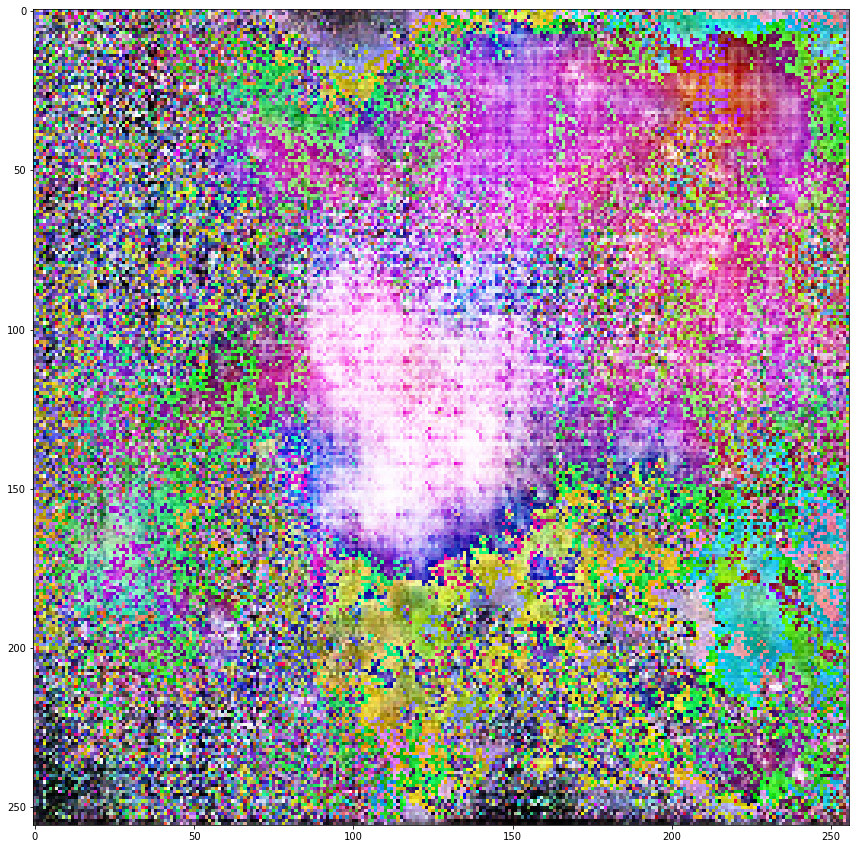

In [ ]:
generated_images = generator.predict(np.random.uniform(-1, 1, size=(1, 100)))
plt.figure(figsize=(15, 15))
#print(generated_images) 
#for i, image in enumerate(generated_images): 
    #plt.subplot(10, 10, i+1)

    #print(generated_images[5]) 
#_ = plt.imshow(np.clip(generated_images[0, :, :, :].reshape((256, 256, 3)), 0.0, 1.0))
image = generated_images[0, :, :, :]   
image = np.reshape(image, [256, 256, 3])     
_ = plt.imshow((image*255).astype(np.uint8))  
#_ = plt.imshow(image)
#plt.tight_layout()




In [ ]:
discriminator.trainable = False
gan.save('/content/drive/MyDrive/Trained-Models-Nebulae/Nebulae_GAN-RGBv2.h5')
discriminator.trainable = True 
generator.save('/content/drive/MyDrive/Trained-Models-Nebulae/Generator_Nebulae-GAN-RGBv2.h5')
discriminator.save('/content/drive/MyDrive/Trained-Models-Nebulae/Discriminator_Nebulae-GAN-RGBv2.h5')

In [ ]:
gan.summary()
print("-------------------------------------------------")
discriminator.summary()
print("-------------------------------------------------")
generator.summary()